## Machine Learning 프로젝트 수행을 위한 코드 구조화 

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [1]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [2]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost.sklearn import XGBClassifier, XGBRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 데이터를 불러옵니다.
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/elec_consumption/train.csv',
                    encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/elec_consumption/test.csv',
                   encoding='cp949')

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [5]:
## On your Own
train.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유'],
      dtype='object')

In [6]:
train.columns = ['num', 'date_time', 'target', 'temperature', 'windspeed',
                 'humidity', 'precipitation', 'insolation', 'cool_flag', 'solar_flag']

test.columns = ['num', 'date_time', 'temperature', 'windspeed',
                 'humidity', 'precipitation', 'insolation', 'cool_flag', 'solar_flag']

<ipython-input-7-53e77fbccc9d>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train, x="date_time", y="target", ci=None)


<Axes: xlabel='date_time', ylabel='target'>

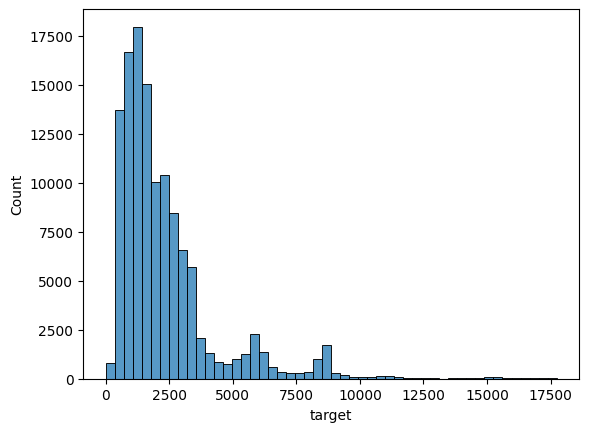

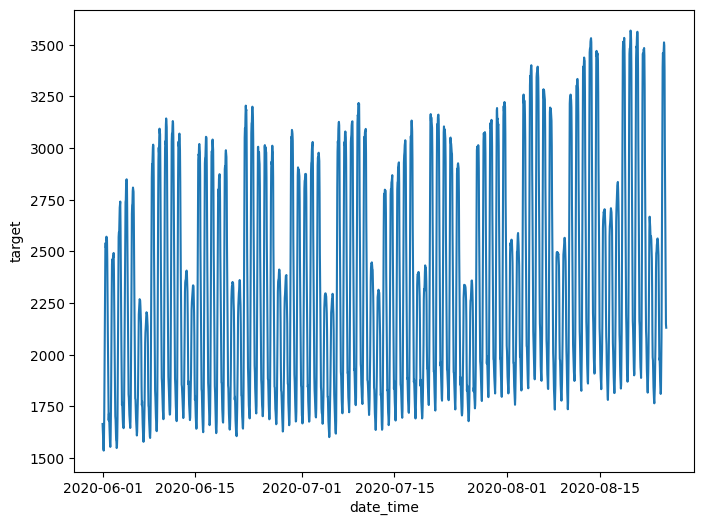

In [7]:
# EDA : target value distribution
train.date_time = pd.to_datetime(train.date_time) # object -> datetime64[ns]

plt.figure()
sns.histplot(data=train, x="target", bins=50)
plt.figure(figsize=(8, 6))
sns.lineplot(data=train, x="date_time", y="target", ci=None)

In [8]:
# 건물별로 전력사용량 그래프를 그려보기

for num in range(1, 61):
    plt.figure(figsize=(8, 6))
    plt.title(f"Building Num {num}", fontsize=14)
    sns.lineplot(data=train[train.num == num], x="date_time", y="target")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

1. 전력사용량의 패턴 찾기

> 비슷한 전력사용량 패턴인 건물들을 묶자 --> 클러스터링!


> 클러스터링(K-means)을 하려면, 어떤 것들을 정의해야할까? --> feature vector


> 건물별 전력사용량 패턴(X)을 어떻게 수치화할것인가?

  0%|          | 0/19 [00:00<?, ?it/s]

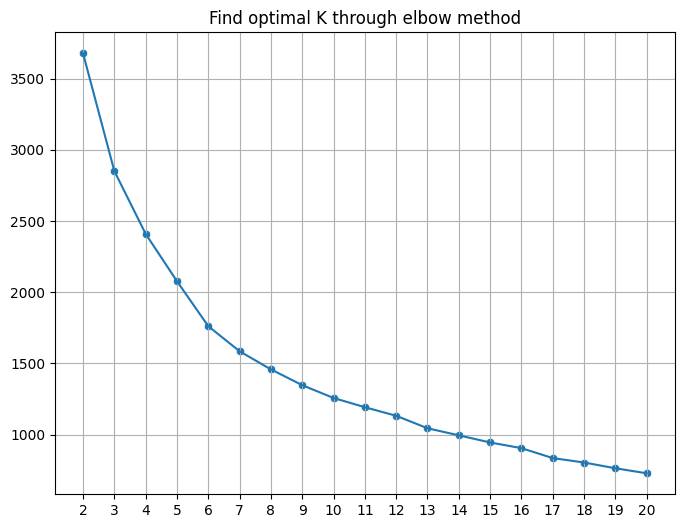

In [9]:
## TO-DO : 아래 코드를 완성해서, 전력사용량 패턴이 비슷한 건물들을 하나의 그룹으로 만들어주는 num_group column을 채워보세요.
# 고민해야할 포인트 1. 아까 그림 그린거를 어떻게 숫자로 만들지?
# 고민해야할 포인트 2. 숫자로 만든거를 KMeans의 input으로 어떻게 넣지?
# 고민해야할 포인트 3. K는 얼마로 하지?

from sklearn.cluster import KMeans
from tqdm.auto import tqdm  # progress bar
from sklearn.preprocessing import MinMaxScaler

X = pd.DataFrame()
for num in range(1, 61):
    X[num] = train[train.num == num].target.reset_index(drop=True)

# 건물별로 min-max scaling(O)
scaler = MinMaxScaler() # column 단위로 min-max scaling.
X = scaler.fit_transform(X)
X = X.T  # transpose (np.array, pd.DataFrame 둘 다 가능)

Ks = range(2, 21) # x-axis
sses = [] # y-axis
labels = []

for K in tqdm(Ks):
    model = KMeans(n_clusters=K, n_init=30, random_state=42)
    label = model.fit_predict(X) # cluster label
    sse = model.inertia_
    labels.append(label)
    sses.append(sse)

# elbow method
plt.figure(figsize=(8, 6))
plt.title("Find optimal K through elbow method", fontsize=12)
plt.xticks(Ks)
plt.grid(True)
sns.lineplot(x=Ks, y=sses)
sns.scatterplot(x=Ks, y=sses)
plt.show()

# select optimal K
label = labels[4] # n_clusters=6

In [10]:
# JOIN (merge)
cluster_info = pd.DataFrame({"num" : train.num.unique(), "num_group" : label})
train = pd.merge(train, cluster_info, on='num')
train

,num,date_time,target,temperature,windspeed,humidity,precipitation,insolation,cool_flag,solar_flag,num_group
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,3
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,3
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,3
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2


In [11]:
cluster_info.num_group.value_counts()

4    17
0    13
1    11
5     8
2     7
3     4
Name: num_group, dtype: int64

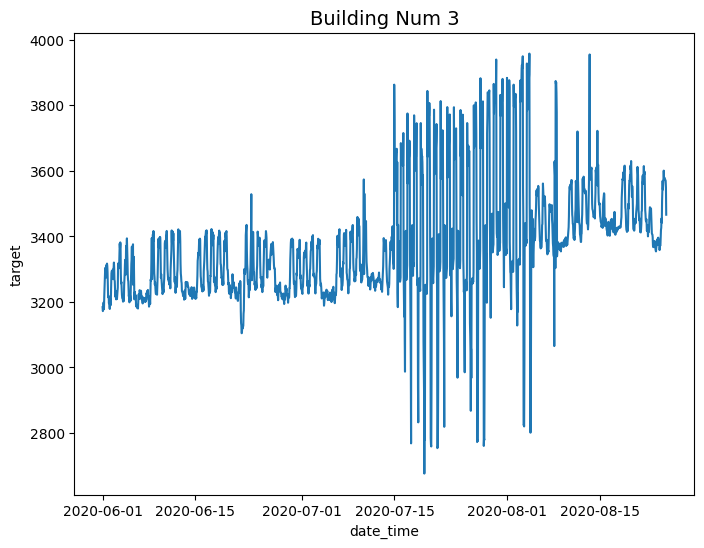

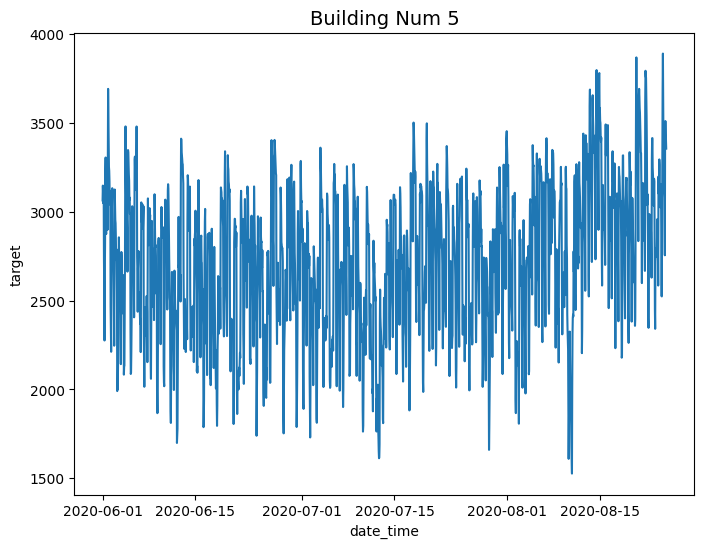

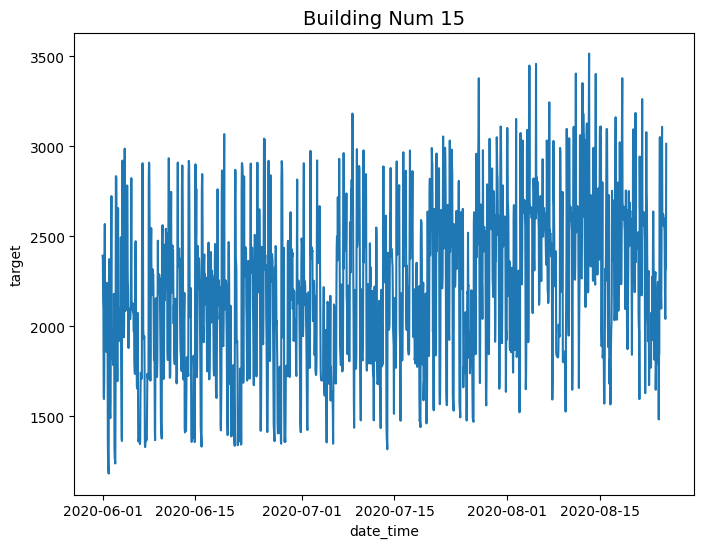

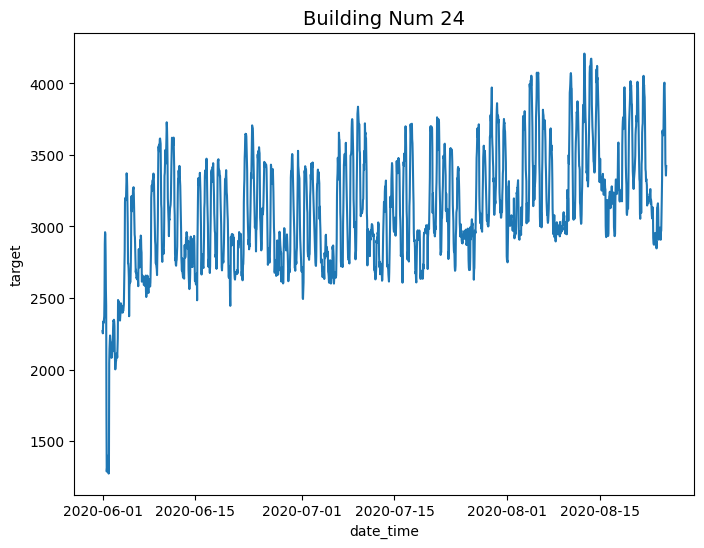

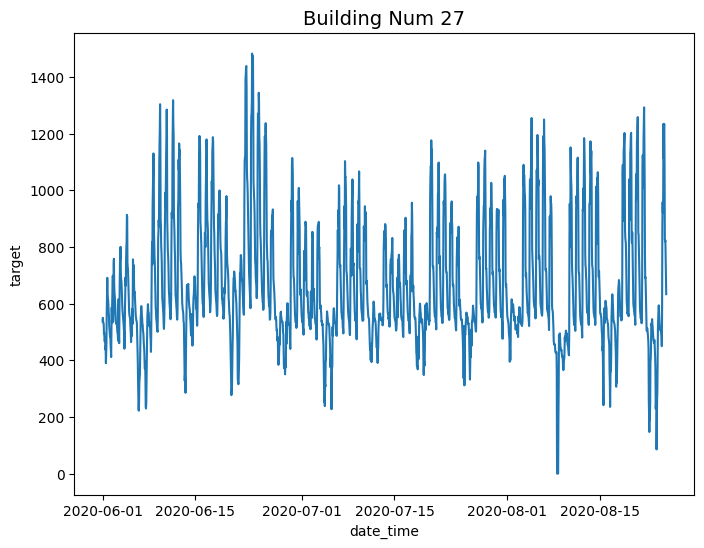

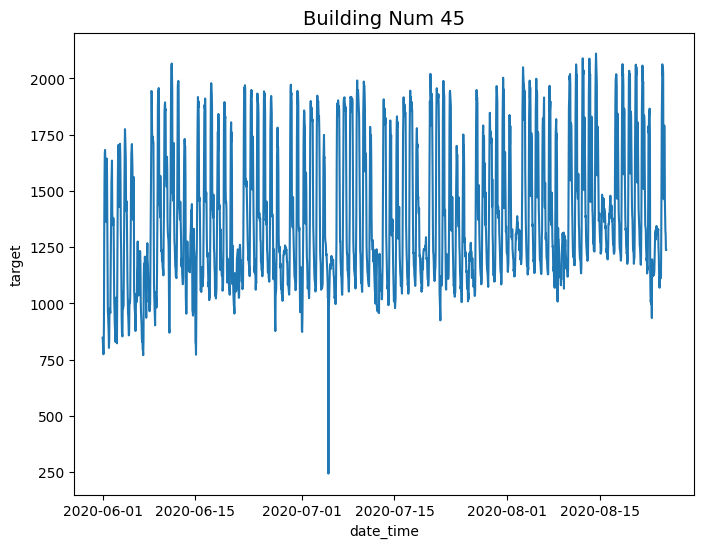

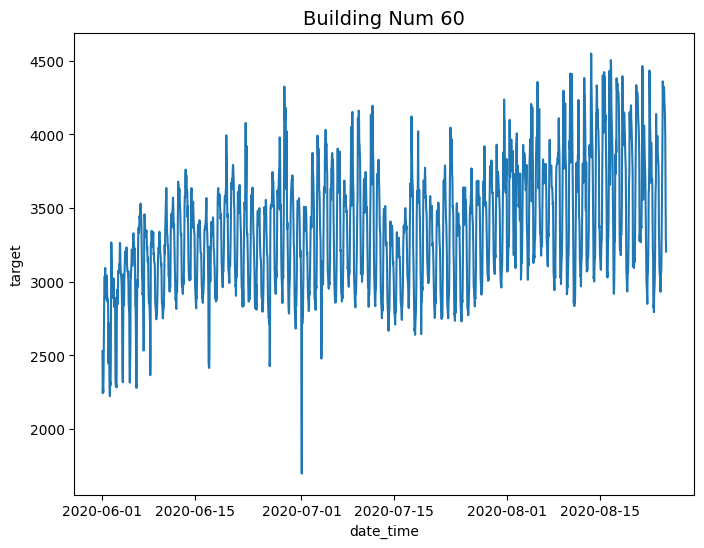

In [12]:
cluster_info[cluster_info.num_group == 3] # [1, 9, 31, 33]
cluster_info[cluster_info.num_group == 2] # [3, 5, 15, 24, 27, 45, 60]

for num in [3, 5, 15, 24, 27, 45, 60]:
    plt.figure(figsize=(8, 6))
    plt.title(f"Building Num {num}", fontsize=14)
    sns.lineplot(data=train[train.num == num], x="date_time", y="target")
    plt.show()

#### Time feature (derived feature)

- date_time column에 시간과 관련된 정보들이 있다.


- month, day, dayofweek, hour를 date_time column에서 추출해서 feature로 만든다.

In [13]:
# make time feature

train['month'] = train.date_time.dt.month
train['day'] = train.date_time.dt.day
train['dow'] = train.date_time.dt.dayofweek # 0:Mon, ..., 6:Sun
train['hour'] = train.date_time.dt.hour
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122400 entries, 0 to 122399
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num            122400 non-null  int64         
 1   date_time      122400 non-null  datetime64[ns]
 2   target         122400 non-null  float64       
 3   temperature    122400 non-null  float64       
 4   windspeed      122400 non-null  float64       
 5   humidity       122400 non-null  float64       
 6   precipitation  122400 non-null  float64       
 7   insolation     122400 non-null  float64       
 8   cool_flag      122400 non-null  float64       
 9   solar_flag     122400 non-null  float64       
 10  num_group      122400 non-null  int32         
 11  month          122400 non-null  int64         
 12  day            122400 non-null  int64         
 13  dow            122400 non-null  int64         
 14  hour           122400 non-null  int64         
dtype

### 4. 학습 데이터 분할

In [14]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X = train.drop(columns=["num", "date_time", "target"])
y = train.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(97920, 12) (97920,) (24480, 12) (24480,)


### 5. 학습 및 평가

In [19]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

# reg = LGBMRegressor(num_leaves=31,
#                     max_depth=-1,
#                     learning_rate=0.1,
#                     n_estimators=100,
#                     min_child_samples=20,
#                     colsample_bytree=1.0,
#                     reg_lambda=0,
#                     random_state=42,
#                     n_jobs=-1,
#                     device='gpu')

reg = XGBRegressor(tree_method='gpu_hist') # GPU-Acceleration

In [20]:
#print("\nFitting LightGBM...")
print("\nFitting XGBoost...")
reg.fit(X_train, y_train)


Fitting XGBoost...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
from sklearn.metrics import mean_absolute_error
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = mean_absolute_error

In [22]:
print("Prediction")
pred_train = reg.predict(X_train)
pred_val = reg.predict(X_val)

train_score = evaluation_metric(y_train, pred_train)
val_score = evaluation_metric(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)

Prediction
Train Score : 755.7630
Validation Score : 786.5410


### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [25]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'num_leaves' : [63, 255],
#     'max_depth' : [4, 6],
#     'learning_rate': [0.1, 0.01],
#     'n_estimators': [200],
#     'min_child_samples' : [20, 50],
#     'colsample_bytree': [0.5, 0.7],
#     'reg_lambda' : [0.1],
#     'device' : 'gpu'
# } # 2x2x2x1x2x2

param_grid = {
    'max_depth' : [4, 6],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [200, 500],
    'min_child_samples' : [20, 50],
    'colsample_bytree': [0.5, 0.7],
    'reg_lambda' : [0.1, 1],
    'tree_method' : ['gpu_hist']
}

# cv=5 --> validation size 1/5 (20%) X 5 # [3, 4, 5, 6, 7]
gcv = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=3)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[05:55:06] WARNING: ../src/learner.cc:767: 
Parameters: { "min_child_samples" } are not used.

Best Estimator :  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_samples=20, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)


In [26]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_val = gcv.predict(X_val)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_val_score = evaluation_metric(y_val, gcv_pred_val)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_val_score)

Prediction with Best Estimator
Train MAE Score : 727.2982
Test MAE Score : 773.1721


> optuna를 사용해봅시다 !

In [27]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 4, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.7)
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    # model = LGBMRegressor(n_estimators=n_estimators,
    #                       max_depth=max_depth,
    #                       colsample_bytree=colsample_bytree,
    #                       n_jobs=-1,                # CPU parallize
    #                       random_state=42)
    
    model = XGBRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                         colsample_bytree=colsample_bytree,
                         tree_method='gpu_hist',     # GPU-acceleration
                         random_state=42)
    
    # K-Fold Cross validation을 구현합니다. (= GridSearchCV에 있는 cv option을 직접 구현.)
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)



In [28]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=10)

[I 2023-06-08 06:05:27,156] A new study created in memory with name: no-name-d8a9fe71-8b0d-449e-9120-8bc972e4e0b3
[I 2023-06-08 06:05:29,071] Trial 0 finished with value: 861.9594352208272 and parameters: {'n_estimators': 88, 'max_depth': 5, 'colsample_bytree': 0.558626799184089}. Best is trial 0 with value: 861.9594352208272.
[I 2023-06-08 06:05:30,962] Trial 1 finished with value: 827.3915811779465 and parameters: {'n_estimators': 84, 'max_depth': 7, 'colsample_bytree': 0.5617999899980571}. Best is trial 1 with value: 827.3915811779465.
[I 2023-06-08 06:05:32,203] Trial 2 finished with value: 895.3346403173986 and parameters: {'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.5201498026250907}. Best is trial 1 with value: 827.3915811779465.
[I 2023-06-08 06:05:33,702] Trial 3 finished with value: 845.3918843776133 and parameters: {'n_estimators': 81, 'max_depth': 6, 'colsample_bytree': 0.5465412380533867}. Best is trial 1 with value: 827.3915811779465.
[I 2023-06-08 06:05:35

In [29]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_max_depth,params_n_estimators,state
0,0,861.959435,2023-06-08 06:05:27.162996,2023-06-08 06:05:29.071002,0 days 00:00:01.908006,0.558627,5,88,COMPLETE
1,1,827.391581,2023-06-08 06:05:29.075553,2023-06-08 06:05:30.962453,0 days 00:00:01.886900,0.561800,7,84,COMPLETE
2,2,895.334640,2023-06-08 06:05:30.964385,2023-06-08 06:05:32.203016,0 days 00:00:01.238631,0.520150,4,100,COMPLETE
3,3,845.391884,2023-06-08 06:05:32.204888,2023-06-08 06:05:33.701858,0 days 00:00:01.496970,0.546541,6,81,COMPLETE
4,4,836.107567,2023-06-08 06:05:33.706018,2023-06-08 06:05:35.920042,0 days 00:00:02.214024,0.573342,7,58,COMPLETE
5,5,923.933320,2023-06-08 06:05:35.931695,2023-06-08 06:05:37.875590,0 days 00:00:01.943895,0.562396,4,67,COMPLETE
6,6,869.389060,2023-06-08 06:05:37.879870,2023-06-08 06:05:39.031818,0 days 00:00:01.151948,0.584945,5,50,COMPLETE
7,7,852.476748,2023-06-08 06:05:39.036334,2023-06-08 06:05:40.432713,0 days 00:00:01.396379,0.620955,5,76,COMPLETE
8,8,881.227657,2023-06-08 06:05:40.436579,2023-06-08 06:05:41.463401,0 days 00:00:01.026822,0.557078,5,50,COMPLETE
9,9,836.507126,2023-06-08 06:05:41.467208,2023-06-08 06:05:43.148957,0 days 00:00:01.681749,0.551733,6,95,COMPLETE


In [30]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 827.3916
Best params:  {'n_estimators': 84, 'max_depth': 7, 'colsample_bytree': 0.5617999899980571}


In [31]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [32]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

<Axes: ylabel='temperature'>

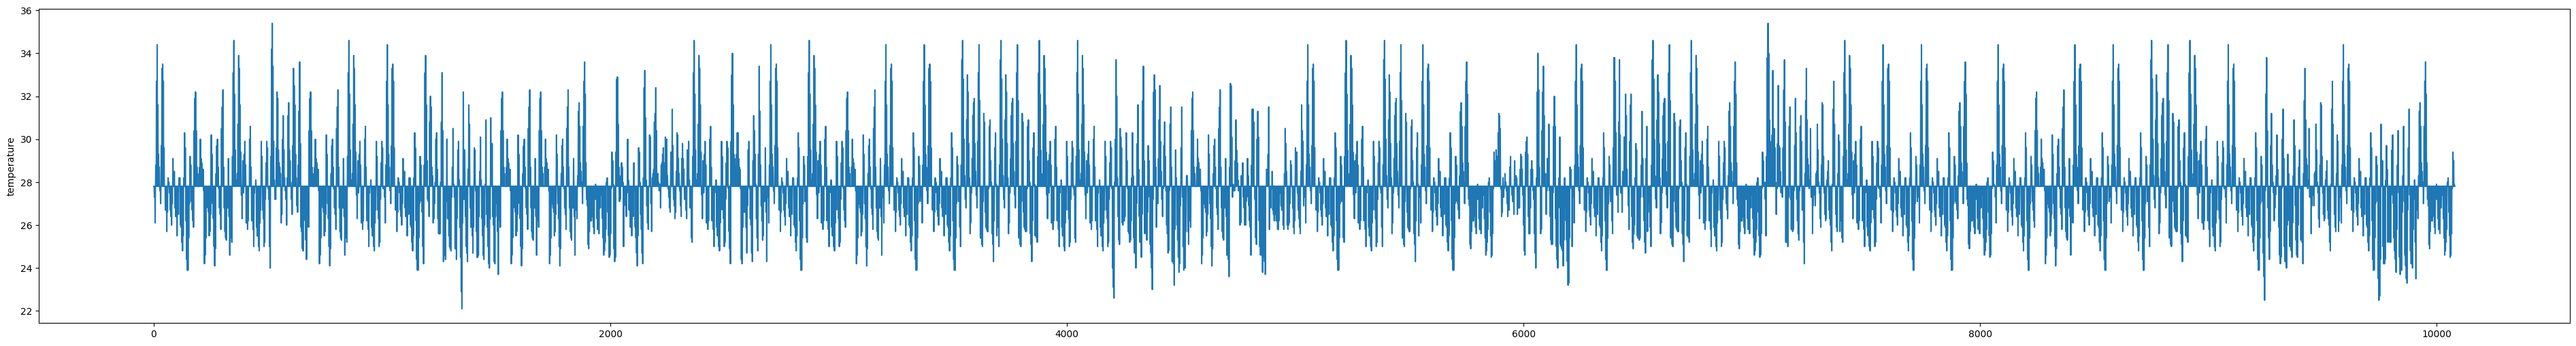

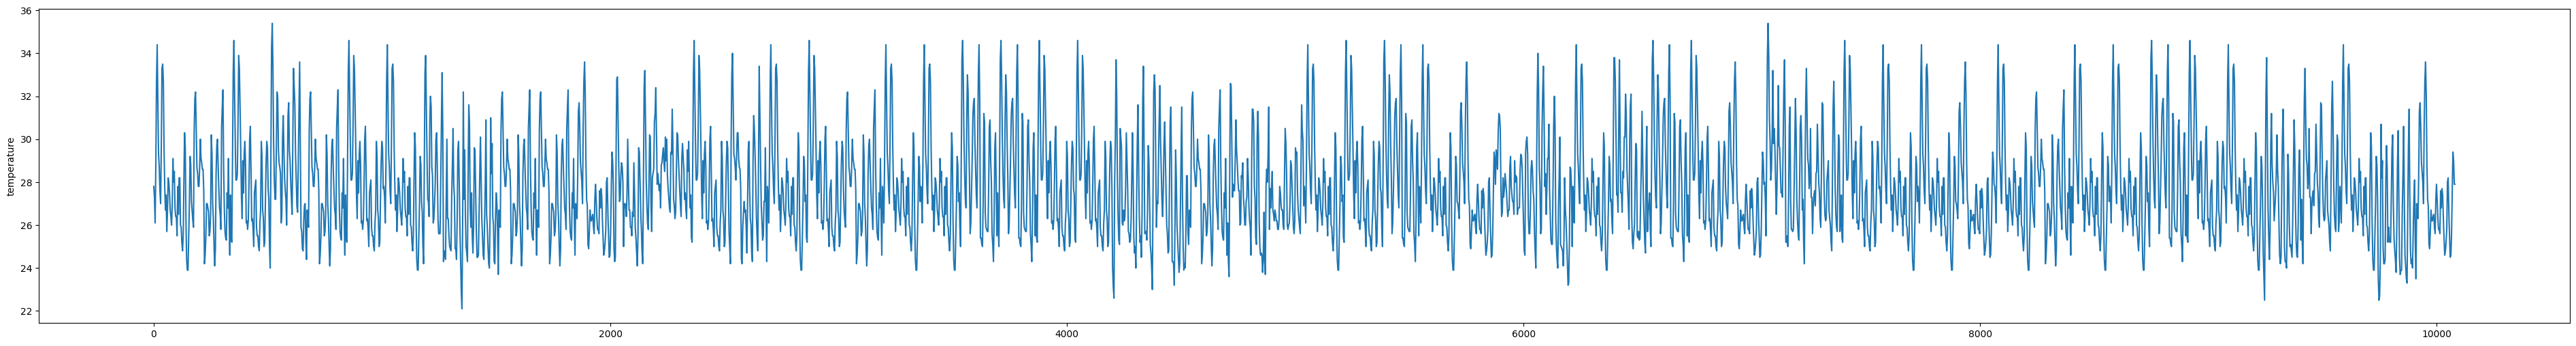

In [41]:
# 결측치 핸들링
# 1. 기상정보 --> linear interpolation!
#sns.lineplot(test.temperature.fillna(test.temperature.mean()))
plt.figure(figsize=(48, 6))
#sns.scatterplot(test.temperature.fillna(test.temperature.mean())) # (X)
sns.lineplot(test.temperature.fillna(test.temperature.mean())) # (X)

## linear interpolation (선형 보간법)
plt.figure(figsize=(48, 6))
#sns.scatterplot(test.temperature.interpolate(method='linear')) # (O)
sns.lineplot(test.temperature.interpolate(method='linear')) # (O)

In [46]:
# 2. 건물정보 --> 비전기냉방설비운영 & 태양광보유 는 아마 건물별로 같지 않을까? ---> 그럼 train과 test가 같은지 보자.
#test[["cool_flag", "solar_flag"]]
#train[["num", "cool_flag", "solar_flag"]].value_counts()
train[["num", "cool_flag", "solar_flag"]].drop_duplicates()

## TO-DO ###
# 1. test에 NaN을 0으로 채운뒤에, train과 같은지 비교.

# 2. 아니라면, 어떻게 채울지 고민 후 구현.

,num,cool_flag,solar_flag
0,1,0.0,0.0
2040,2,1.0,0.0
4080,3,1.0,1.0
6120,4,1.0,1.0
8160,5,1.0,0.0
10200,6,0.0,0.0
12240,7,1.0,0.0
14280,8,1.0,1.0
16320,9,0.0,1.0
18360,10,1.0,0.0


In [ ]:
## X_test 만들기

#### TO-DO ####
# 3. train 데이터에서 했던 모든 전처리를 사용.

## num_group 추가하기
## time feature 추가하기
## column수를 12개로 맞춘 뒤에, 학습이 완료된 모델에 inference가 되는지 확인!

X_test = 


In [ ]:
best_params = 

best_model = RandomForestRegressor(**best_params)

best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission

In [ ]:
submission.to_csv("submission.csv", index=False)